**Apache Spark Streaming**

The goal of this project is to use Apache Spark to orchestrate time-based aggregations, leveraging tumbling windows for insights into the data. As it is difficult to find publicly available streaming data, a csv file containing sales data for Amazon India was selected as the data source. For the analysis, I decided to use tumbling windows which are fixed and non-overlapping time intervals. Because my data is static, tumbling windows will give more consistent results that are not redundant. Sliding windows are more performant for streaming data which needs to be updated as data is received, but would introduce unnecessary complexity into my analysis.

In [15]:
# install pyspark
!pip install pyspark

In [2]:
# importing libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import window, sum
from pyspark.sql import functions as F
from pyspark.sql.functions import col, to_date
from pyspark.sql.functions import date_trunc
from pyspark.sql.window import Window
from pyspark.sql.functions import lit
import matplotlib.pyplot as plt
from pyspark.sql.functions import date_format
import matplotlib.dates as mdates

In [3]:
# create the spark session
spark = SparkSession.builder \
    .appName("Time_Based_Aggregations") \
    .getOrCreate()

In [4]:
# read in csv file
ecommerce_df = spark.read \
    .format("csv") \
    .option("header", "true") \
    .load('amazon_report.csv')

In [5]:
# list columns to drop
col_drop = ['Order ID', 'Style', 'SKU', 'ASIN', 'Courier Status', 'promotion-ids', 'B2B', 'fulfilled-by', 'Unnamed: 22', 'ship-country', 'currency']

# drop the columns
ecommerce_df = ecommerce_df.drop(*col_drop)

In [6]:
# df check
ecommerce_df.show(5)

+-----+--------+--------------------+----------+--------------+------------------+-------------+----+---+------+-----------+-----------+----------------+
|index|    Date|              Status|Fulfilment|Sales Channel |ship-service-level|     Category|Size|Qty|Amount|  ship-city| ship-state|ship-postal-code|
+-----+--------+--------------------+----------+--------------+------------------+-------------+----+---+------+-----------+-----------+----------------+
|    0|04-30-22|           Cancelled|  Merchant|     Amazon.in|          Standard|          Set|   S|  0|647.62|     MUMBAI|MAHARASHTRA|        400081.0|
|    1|04-30-22|Shipped - Deliver...|  Merchant|     Amazon.in|          Standard|        kurta| 3XL|  1| 406.0|  BENGALURU|  KARNATAKA|        560085.0|
|    2|04-30-22|             Shipped|    Amazon|     Amazon.in|         Expedited|        kurta|  XL|  1| 329.0|NAVI MUMBAI|MAHARASHTRA|        410210.0|
|    3|04-30-22|           Cancelled|  Merchant|     Amazon.in|          Sta

In [7]:
# retain only rows where 'Sales Channel' is 'Amazon.in'
ecommerce_df = ecommerce_df.filter(F.col('Sales Channel ') != 'Non-Amazon')

# show df
ecommerce_df.show(5)

+-----+--------+--------------------+----------+--------------+------------------+-------------+----+---+------+-----------+-----------+----------------+
|index|    Date|              Status|Fulfilment|Sales Channel |ship-service-level|     Category|Size|Qty|Amount|  ship-city| ship-state|ship-postal-code|
+-----+--------+--------------------+----------+--------------+------------------+-------------+----+---+------+-----------+-----------+----------------+
|    0|04-30-22|           Cancelled|  Merchant|     Amazon.in|          Standard|          Set|   S|  0|647.62|     MUMBAI|MAHARASHTRA|        400081.0|
|    1|04-30-22|Shipped - Deliver...|  Merchant|     Amazon.in|          Standard|        kurta| 3XL|  1| 406.0|  BENGALURU|  KARNATAKA|        560085.0|
|    2|04-30-22|             Shipped|    Amazon|     Amazon.in|         Expedited|        kurta|  XL|  1| 329.0|NAVI MUMBAI|MAHARASHTRA|        410210.0|
|    3|04-30-22|           Cancelled|  Merchant|     Amazon.in|          Sta

In [8]:
# drop the Sales Channel column
# list columns to drop
col_drop = ['Sales Channel ']

# drop the columns
ecommerce_df = ecommerce_df.drop(*col_drop)

In [9]:
# count num rows in df
num_rows = ecommerce_df.count()

print("Number of rows:", num_rows)

Number of rows: 128851


In [10]:
# code to check the data types of columns in the df
ecommerce_df.printSchema()

root
 |-- index: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Fulfilment: string (nullable = true)
 |-- ship-service-level: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Qty: string (nullable = true)
 |-- Amount: string (nullable = true)
 |-- ship-city: string (nullable = true)
 |-- ship-state: string (nullable = true)
 |-- ship-postal-code: string (nullable = true)



In [11]:
# convert 'Date' column to date object since there is no time
ecommerce_df = ecommerce_df.withColumn("Date", to_date(col("Date"), "MM-dd-yy"))

In [12]:
# check to see if dates are still properly stored
ecommerce_df.show(5)

+-----+----------+--------------------+----------+------------------+-------------+----+---+------+-----------+-----------+----------------+
|index|      Date|              Status|Fulfilment|ship-service-level|     Category|Size|Qty|Amount|  ship-city| ship-state|ship-postal-code|
+-----+----------+--------------------+----------+------------------+-------------+----+---+------+-----------+-----------+----------------+
|    0|2022-04-30|           Cancelled|  Merchant|          Standard|          Set|   S|  0|647.62|     MUMBAI|MAHARASHTRA|        400081.0|
|    1|2022-04-30|Shipped - Deliver...|  Merchant|          Standard|        kurta| 3XL|  1| 406.0|  BENGALURU|  KARNATAKA|        560085.0|
|    2|2022-04-30|             Shipped|    Amazon|         Expedited|        kurta|  XL|  1| 329.0|NAVI MUMBAI|MAHARASHTRA|        410210.0|
|    3|2022-04-30|           Cancelled|  Merchant|          Standard|Western Dress|   L|  0|753.33| PUDUCHERRY| PUDUCHERRY|        605008.0|
|    4|2022-0

In [13]:
# check if there are null values in the 'Date' column
non_null_count = ecommerce_df.filter(col("Date").isNull()).count()
non_null_count

0

In [14]:
# check the range of values in the Date column
min_date = ecommerce_df.select(col("Date")).agg({"Date": "min"}).collect()[0][0]
max_date = ecommerce_df.select(col("Date")).agg({"Date": "max"}).collect()[0][0]

print("Minimum Date:", min_date)
print("Maximum Date:", max_date)

Minimum Date: 2022-03-31
Maximum Date: 2022-06-29


MONTHLY AGGREGATED ORDER VOLUME

In [16]:
# define tumbling windows for each month
window_1 = (F.col("Date").between("2022-04-01", "2022-04-30"))
window_2 = (F.col("Date").between("2022-05-01", "2022-05-31"))
window_3 = (F.col("Date").between("2022-06-01", "2022-06-29"))

# calculate order volume for each window
order_volume_window_1 = ecommerce_df.filter(window_1).agg(F.sum("Qty").alias("OrderVolume_April"))
order_volume_window_2 = ecommerce_df.filter(window_2).agg(F.sum("Qty").alias("OrderVolume_May"))
order_volume_window_3 = ecommerce_df.filter(window_3).agg(F.sum("Qty").alias("OrderVolume_June"))

In [17]:
# adding month column
monthly_df_1 = order_volume_window_1.withColumn("Month", lit("April")).withColumnRenamed("OrderVolume_April", "OrderVolume")

monthly_df_2 = order_volume_window_2.withColumn("Month", lit("May")).withColumnRenamed("OrderVolume_May", "OrderVolume")

monthly_df_3 = order_volume_window_3.withColumn("Month", lit("June")).withColumnRenamed("OrderVolume_June", "OrderVolume")

# combining results
monthly_df = monthly_df_1.union(monthly_df_2).union(monthly_df_3)

# put month column on the left
monthly_df = monthly_df.select("Month", "OrderVolume")

# show df
monthly_df.show(truncate=False)

+-----+-----------+
|Month|OrderVolume|
+-----+-----------+
|April|44111.0    |
|May  |37970.0    |
|June |34245.0    |
+-----+-----------+



Bar plot showing Order Volume by Month

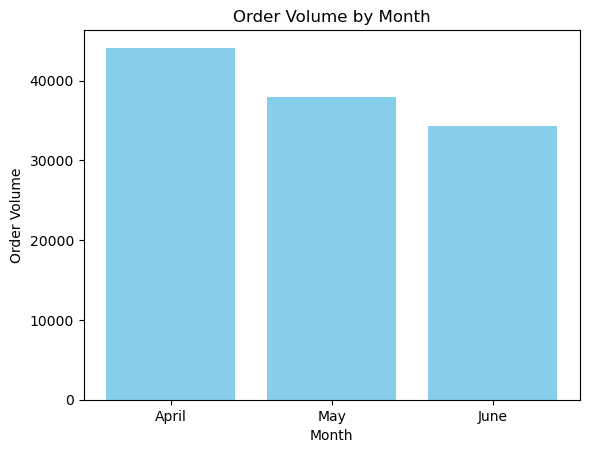

In [18]:
# extract data from df
months = monthly_df.select("Month").collect()
order_volumes = monthly_df.select("OrderVolume").collect()

# extract data from row object
months = [row["Month"] for row in months]
order_volumes = [row["OrderVolume"] for row in order_volumes]

# plot
plt.bar(months, order_volumes, color='skyblue')
plt.title('Order Volume by Month')
plt.xlabel('Month')
plt.ylabel('Order Volume')
plt.show()

WEEKLY AGGREGATED ORDER VOLUME

In [20]:
# define tumbling window for 7 days
# tumbling_window = Window.orderBy("Date").rangeBetween(0, 6)

# get order volume for every 7 days
order_volume_per_week = ecommerce_df \
    .groupBy(F.window("Date", "7 days")) \
    .agg(F.sum("Qty").alias("OrderVolume")) \
    .orderBy("window.start") \
    .select(
        F.col("window").alias("Week"),
        F.col("OrderVolume")
    )

# remove the time notation
weekly_df = order_volume_per_week.withColumn("Week", F.date_format("Week.start", "yyyy-MM-dd"))

# print results
weekly_df.show(truncate=False)

+----------+-----------+
|Week      |OrderVolume|
+----------+-----------+
|2022-03-31|8673.0     |
|2022-04-07|10153.0    |
|2022-04-14|10874.0    |
|2022-04-21|10491.0    |
|2022-04-28|11296.0    |
|2022-05-05|8528.0     |
|2022-05-12|7519.0     |
|2022-05-19|7529.0     |
|2022-05-26|8549.0     |
|2022-06-02|9431.0     |
|2022-06-09|8950.0     |
|2022-06-16|7773.0     |
|2022-06-23|6716.0     |
+----------+-----------+



Bar plot showing Order Volume by Week

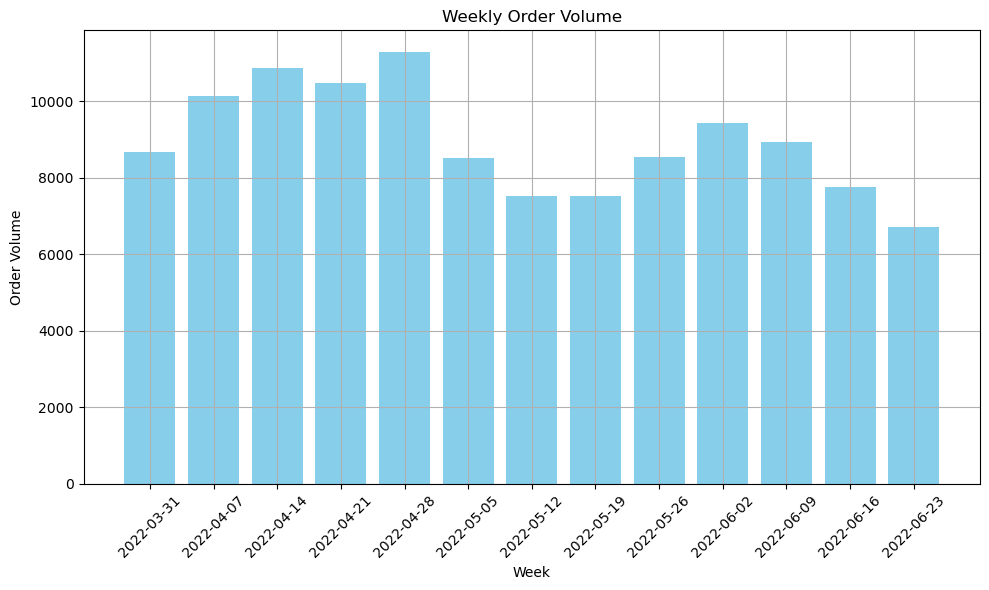

In [21]:
# extract data from df
weeks = weekly_df.select("Week").collect()
order_volumes = weekly_df.select("OrderVolume").collect()

# extract values from row objects
weeks = [row["Week"] for row in weeks]
order_volumes = [row["OrderVolume"] for row in order_volumes]

# plot bar plot
plt.figure(figsize=(10, 6))
plt.bar(weeks, order_volumes, color='skyblue')
plt.title('Weekly Order Volume')
plt.xlabel('Week')
plt.ylabel('Order Volume')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Line plot showing Order Volume by Week

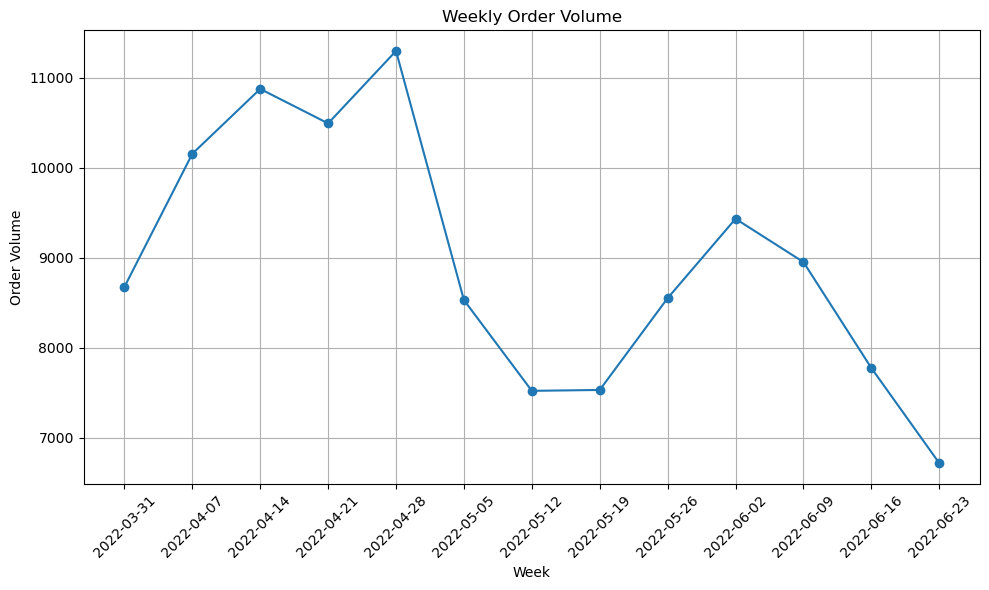

In [22]:
# plot line plot
plt.figure(figsize=(10, 6))
plt.plot(weeks, order_volumes, marker='o', linestyle='-')
plt.title('Weekly Order Volume')
plt.xlabel('Week')
plt.ylabel('Order Volume')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

DAILY AGGREGATED ORDER VOLUME

In [23]:
# group by date and sum Qty
daily_order_volume = ecommerce_df.groupBy("Date").agg(F.sum("Qty").alias("OrderVolume"))

# sort by date
daily_df = daily_order_volume.orderBy("Date")

# print
daily_df.show(truncate=False)

+----------+-----------+
|Date      |OrderVolume|
+----------+-----------+
|2022-03-31|156.0      |
|2022-04-01|1319.0     |
|2022-04-02|1408.0     |
|2022-04-03|1544.0     |
|2022-04-04|1330.0     |
|2022-04-05|1486.0     |
|2022-04-06|1430.0     |
|2022-04-07|1377.0     |
|2022-04-08|1519.0     |
|2022-04-09|1462.0     |
|2022-04-10|1619.0     |
|2022-04-11|1396.0     |
|2022-04-12|1301.0     |
|2022-04-13|1479.0     |
|2022-04-14|1694.0     |
|2022-04-15|1620.0     |
|2022-04-16|1538.0     |
|2022-04-17|1445.0     |
|2022-04-18|1395.0     |
|2022-04-19|1486.0     |
+----------+-----------+
only showing top 20 rows



Line plot showing Order Volume by Day

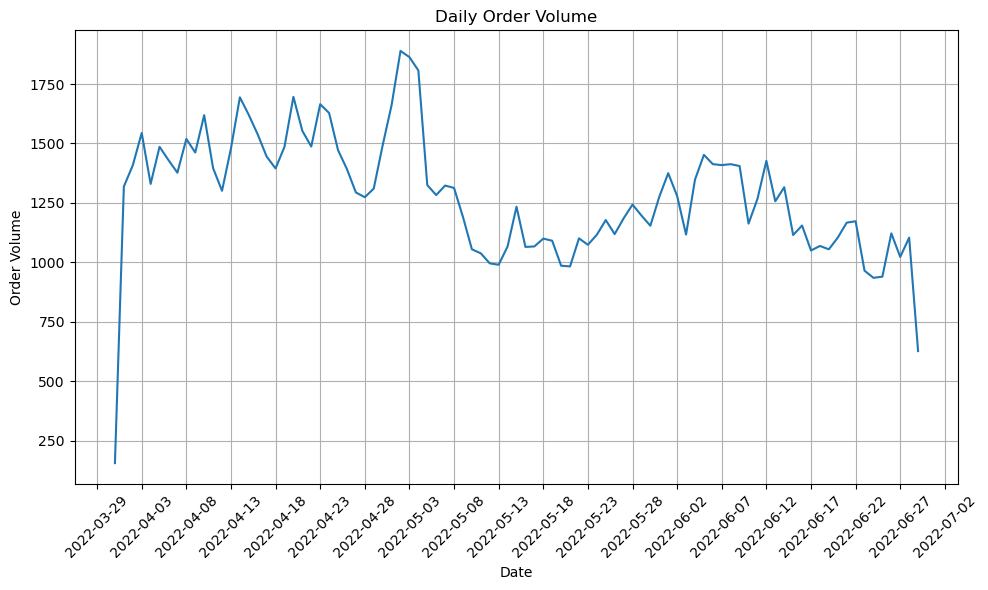

In [24]:
# extract data from df
dates = daily_df.select("Date").collect()
order_volumes = daily_df.select("OrderVolume").collect()

# extract values from row objects
dates = [row["Date"] for row in dates]
order_volumes = [row["OrderVolume"] for row in order_volumes]

# plot
plt.figure(figsize=(10, 6))
plt.plot(dates, order_volumes, linestyle='-')
plt.title('Daily Order Volume')
plt.xlabel('Date')
plt.ylabel('Order Volume')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

PERCENTAGE OF EXPEDITED SHIPPING BY MONTH

In [25]:
# filter commerce_df to where the Qty is not 0 (exclude cancelled orders)
not_cancelled_df = ecommerce_df.filter(col('Qty') != 0)

not_cancelled_df.show(5)

+-----+----------+--------------------+----------+------------------+--------+----+---+------+-----------+-------------+----------------+
|index|      Date|              Status|Fulfilment|ship-service-level|Category|Size|Qty|Amount|  ship-city|   ship-state|ship-postal-code|
+-----+----------+--------------------+----------+------------------+--------+----+---+------+-----------+-------------+----------------+
|    1|2022-04-30|Shipped - Deliver...|  Merchant|          Standard|   kurta| 3XL|  1| 406.0|  BENGALURU|    KARNATAKA|        560085.0|
|    2|2022-04-30|             Shipped|    Amazon|         Expedited|   kurta|  XL|  1| 329.0|NAVI MUMBAI|  MAHARASHTRA|        410210.0|
|    4|2022-04-30|             Shipped|    Amazon|         Expedited|     Top| 3XL|  1| 574.0|    CHENNAI|   TAMIL NADU|        600073.0|
|    5|2022-04-30|             Shipped|    Amazon|         Expedited|     Set|  XL|  1| 824.0|  GHAZIABAD|UTTAR PRADESH|        201102.0|
|    6|2022-04-30|             Shi

In [26]:
# windows are the same as before

# filter for rows with "Expedited" ship-service-level
expedited_window_1 = not_cancelled_df.filter(window_1 & (not_cancelled_df["ship-service-level"] == "Expedited"))
expedited_window_2 = not_cancelled_df.filter(window_2 & (not_cancelled_df["ship-service-level"] == "Expedited"))
expedited_window_3 = not_cancelled_df.filter(window_3 & (not_cancelled_df["ship-service-level"] == "Expedited"))

# count the number of rows in each window
total_window_1 = not_cancelled_df.filter(window_1).count()
total_window_2 = not_cancelled_df.filter(window_2).count()
total_window_3 = not_cancelled_df.filter(window_3).count()

# count expedited shipping for each window
expedited_window_1 = expedited_window_1.count()
expedited_window_2 = expedited_window_2.count()
expedited_window_3 = expedited_window_3.count()

# get percentage of expedited shipping
expedited_window_1 = (expedited_window_1 / total_window_1) * 100
expedited_window_2 = (expedited_window_2 / total_window_2) * 100
expedited_window_3 = (expedited_window_3 / total_window_3) * 100

# round percentages to 4 places
expedited_window_1 = round(expedited_window_1, 4)
expedited_window_2 = round(expedited_window_2, 4)
expedited_window_3 = round(expedited_window_3, 4)

In [27]:
# create monthly expedited shipping df
monthly_expedited_df = spark.createDataFrame([
    ("April", expedited_window_1),
    ("May", expedited_window_2),
    ("June", expedited_window_3)
], ["Month", "PercentageExpedited"])

monthly_expedited_df.show(truncate=False)

+-----+-------------------+
|Month|PercentageExpedited|
+-----+-------------------+
|April|69.6723            |
|May  |69.8665            |
|June |74.8557            |
+-----+-------------------+



Bar plot showing Percentage of Expedited Orders by Month

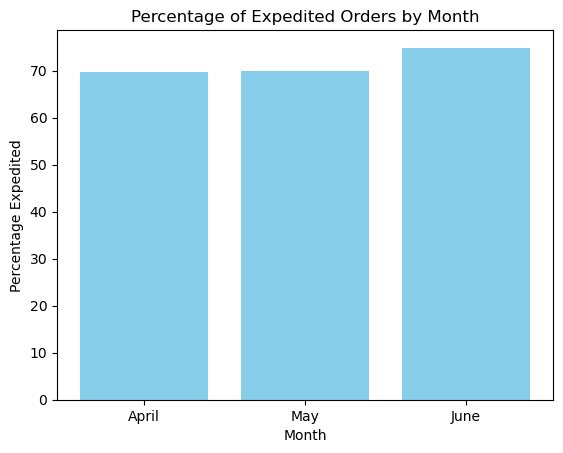

In [28]:
# extract data
months = [row["Month"] for row in monthly_expedited_df.select("Month").collect()]
percentages = [row["PercentageExpedited"] for row in monthly_expedited_df.select("PercentageExpedited").collect()]

# plot
plt.bar(months, percentages, color='skyblue')
plt.title('Percentage of Expedited Orders by Month')
plt.xlabel('Month')
plt.ylabel('Percentage Expedited')
plt.show()

PERCENTAGE OF EXPEDITED SHIPPING BY WEEK

In [29]:
# group by 7 days and calculate total orders and expedited orders
total_weekly_orders = not_cancelled_df \
    .groupBy(F.window("Date", "7 days")) \
    .agg(F.count("*").alias("TotalOrders")) \
    .orderBy("window.start")

# filter df for only expedited orders
expedited_df = not_cancelled_df.filter(not_cancelled_df["ship-service-level"] == "Expedited")

# count expedited orders within each window
expedited_orders_per_week = expedited_df \
    .groupBy(F.window("Date", "7 days")) \
    .agg(F.count("*").alias("ExpeditedOrders")) \
    .orderBy("window.start")

# join dfs to get percentage
joined_df = total_weekly_orders.join(expedited_orders_per_week, on="window", how="left")

# calculate percentage of expedited orders
percentage_expedited = joined_df \
    .withColumn("PercentageExpedited", F.round((F.col("ExpeditedOrders") / F.col("TotalOrders")) * 100, 4)) \
    .select(
        F.col("window").alias("Week"),
        F.col("PercentageExpedited")
    )

# remove the time notation
weekly_expedited_df = percentage_expedited.withColumn("Week", F.date_format("Week.start", "yyyy-MM-dd"))

# sort the weeks in the correct order
window_spec = Window.orderBy("Week")
weekly_expedited_df = weekly_expedited_df.withColumn("row_num", F.row_number().over(window_spec)).orderBy("row_num")

# print results
weekly_expedited_df.select("Week", "PercentageExpedited").show(truncate=False)

+----------+-------------------+
|Week      |PercentageExpedited|
+----------+-------------------+
|2022-03-31|77.5371            |
|2022-04-07|72.1485            |
|2022-04-14|66.5775            |
|2022-04-21|62.8826            |
|2022-04-28|76.8336            |
|2022-05-05|67.603             |
|2022-05-12|57.0267            |
|2022-05-19|67.2177            |
|2022-05-26|79.1696            |
|2022-06-02|76.7274            |
|2022-06-09|77.4849            |
|2022-06-16|71.4157            |
|2022-06-23|72.4571            |
+----------+-------------------+



Bar plot showing Percentage of Expedited Orders by Week

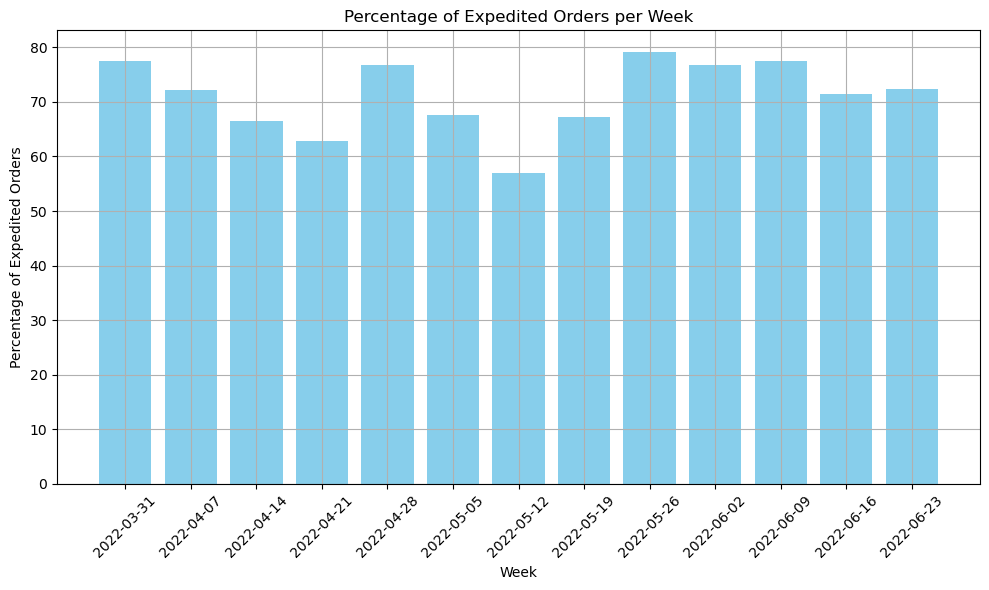

In [30]:
# extract data
weeks = [row['Week'] for row in weekly_expedited_df.collect()]
percentages = [row['PercentageExpedited'] for row in weekly_expedited_df.collect()]

# plot
plt.figure(figsize=(10, 6))
plt.bar(weeks, percentages, color='skyblue')
plt.xlabel('Week')
plt.ylabel('Percentage of Expedited Orders')
plt.title('Percentage of Expedited Orders per Week')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()